## 1. recommendProducts And recommendProducts2 Functions
This notebook contains detailed explanations of the recommendProducts and recommendProducts2 functions provided by the api. These explanations represent the logic behind the functions and show small examples. 

### 1.1. Goal
Given customer id, recommendation type, criteria and product count, return a list of recommended items.

### 1.2. Function Template
#### Input
localhost:8086/recommendProducts?jsonData={"id": 737293, "type": "mix", "Count":5, "criteria": 1}

or

localhost:8086/recommendProducts2?jsonData={"id": 737293, "type": "mix", "Count":5, "criteria": 1}

#### Output
{"Products": [{"id": 597}, {"id": 454}, {"id": 457}, {"id": 553}, {"id": 636}]}

or

{"Products": [{"id": 32823}, {"id": 18110}, {"id": 18109}, {"id": 1808}, {"id": 18107}]}

depending on which function is used. recommendProducts function uses level 3 hierarchy of products (UrunGrup3 information), recommendProducts2 function uses products. 


### 1.3. Logic
In the below sections, the explanations are made based on recommendProduct2 function. Everything is same in both functions except the information of products. recommendProducts function uses IdUrunGrup3 feature of products whereas recommendProducts2 function uses IdUrun information.

We use a state-of-the-art method, Nonnegative Matrix Factorization (NMF) method to find recommended items. A matrix can be considered as a 2-dimensional array. 

In our case, we use SalesMatrix whose rows represent all customers and columns represent all products. Each entry in the matrix represents how much money a customer spent for a product. 

In Figure 1.1, we demonstrated a small, synthetically generated sales matrix. In this case, there are four customers (C0, C1, C2 and C3) and five products (P0, P1, P2, P3, P4) in the database. According to this matrix; customer C0 bought product P0 and paid 1TL, bought product P1 and paid 2.5 TL, did not buy products P2 and P3 etc.  

|Customers|P0|P1|P2|P3|P4|
|--|-------------------------------|
|C0 |1 |2.5|0 |0 |0.5|
|C1 |0 |1 |0.5|1 |0.5|
|C2 |1 |2 |0 |1 |1 |
|C3 |0 |0.5|0 |0.3|0 |

<center>Figure 1.1. Sales Matrix</center>

Given a rank (r, which is smaller than the number of products), NMF decomposes original matrix into two smaller sized matrices. The problem can be represented as:

$$ X \approx W H$$

where X matrix's dimensions are (NC x NP), W matrix's dimensions are (NC x r), H matrix's dimensions are (r x NP), NC is the number of customers, NP is the number of products and r is the rank value.

If we apply NMF for the sales matrix in Figure 1 by using rank=2, we might get the following two matrices (W and H):

|Customers|||
|--|-------------------------------|
|C0 |1 |0 |
|C1 |0.5|0.5|
|C2 |1 |1 |
|C3 |0 |0.3|

<center>Figure 1.2. W Matrix</center>


||P0|P1|P2|P3|P4|
|--|-------------------------------|
||0.1|2 |0.5|0 |1 |
||0.5|1 |0.5|1 |0.3|

<center>Figure 1.3. H Matrix</center>

After generating W and H matrices, we multiply these matrices to get an estimation of the original sales matrix. We called this matrix as SalesMatrixEst, which also has the dimensions (NC x NP). 

|Customers|P0|P1|P2|P3|P4|
|--|-------------------------------|
|C0 |0.1 |2 |0.5 |0 |1  |
|C1 |0.3 |1.5 |0.5|0.5|0.65|
|C2 |0.6 |3 |1  |1 |1.3 |
|C3 |0.15|0.3|0.15 |0.3|0.09|

<center>Figure 1.4. Sales Matrix Estimation</center>

In recommendProducts and recommendProducts2 functions, we compare SalesMatrix and SalesMatrixEst for a given customer and return the result. 

If we analyze the original sales and the sales estimation of customer C0, we have the below chart. Blue bars represent real sales of the customer and red bars represent the sales estimations. X axis corresponds to products and Y axis correspond to the money.  

<img src="../otherFiles/Section1_C0.png">
<center>Figure 1.5. SalesMatrix and SalesMatrixEst comparison for customer C0</center>

We have the following figure for customer C1: 

<img src="../otherFiles/Section1_C1.png">
<center>Figure 1.6. SalesMatrix and SalesMatrixEst comparison for customer C1</center>

### 1.4. Recommender Types
After generating the SalesMatrixEst matrix, given a customer and recommender type, we need to return a list of recommended items. 

There are four different recommender types implemented in the current version of the system:

|Recommender Type|Description|
|--|-------------------------------|
|mix|Returns products without any specific filtering|
|discover|Returns only the products the customer did not purchase yet|
|habit|Returns only the products the customer already purchased |
|difference|Returns the products whose estimated sales values are bigger than the original sales values|

<center>Figure 1.7. Recommender Types</center>

Lets compare the results of each recommender type, when the given customer is C0 (whose original sales and sales estimations are shown in below chart).

<img src="../otherFiles/Section1_C0.png">
<center>Figure 1.8. SalesMatrix and SalesMatrixEst comparison for customer C0</center>

#### mix
When the recommender type is "mix", the function returns products (in sorted order) without any specific filtering. 

In the case of customer CO; the estimations of products (P0, P1, P2, P3, P4) are (0.1, 2, 0.5, 0, 1) respectively. So, we sort the products according to the values in descending order. The recommended products are :

<center>(P1, P4, P2, P0, P3)</center>

#### discover
When the recommender type is "discover", the function returns only the products (in sorted order) the customer did not purchase yet.

In the case of customer CO, we have the following recommended products:

<center>(P2, P3)</center>

#### habit
When the recommender type is "habit", the function returns only the products (in sorted order) the customer already purchased. 

In the case of customer CO, we have the following recommended products:

<center>(P1, P4, P0)</center>

#### difference
When the recommender type is "difference", the function returns the products (in sorted order) whose estimated sales values are bigger than the original sales values.

In the case of customer CO, we have the following recommended products:

<center>(P4, P2)</center>


Overall, for customer C0, we have the following recommended products table for each recommender type:

|Recommender Type|Product Recommendations|
|--|-------------------------------|
|mix|(P1, P4, P2, P0, P3)|
|discover|(P2, P3)|
|habit|(P1, P4, P0)|
|difference|(P4, P2)|
<center>Figure 1.9. Recommended products for customer C0</center>

### 1.5. Criteria 
Criteria parameter defines how the original sales matrix will used during recommendation of the products. 

Criteria may have the following values: 

|Criteria|Description|
|--|-------------------------------|
|1|Total Sales Amount|
|2|Whether a sale is done or not (0 or 1. Binary representation)|

<center>Figure 1.10. Criteria Types</center>

When the criteria is "1", the sales matrix will be used as it is (each entry in the matrix corresponds to the amount of money a customer spent to a product, as demonstrated in section 1.3 of this file). Therefore, the recommendations done by this criteria will describe how much money we expect a customer will spend to a product. 

When the criteria is "2", the sales matrix will converted to a binary representation which shows whether a customer bought a product or not, regardless of how much money he/she spent. The binary representation of original sales tensor is shown below. The recommendations done by this criteria will illustrate whether we expect a customer will buy a product or not. 

|Customers|P0|P1|P2|P3|P4|
|--|-------------------------------|
|C0 |1 |1|0 |0 |1|
|C1 |0 |1 |1|1 |1|
|C2 |1 |1 |0 |1 |1 |
|C3 |0 |1|0 |1|0 |

<center>Figure 1.11. Binary Representation of Sales Matrix</center>

The results of both criteria may differ dramatically. Intiutively, we can say all products purchased by a customer has similar importance when criteria=2. However, when criteria=1, the amount of money spent on a product has importance. 

### 1.6. Count
The count parameter of the function determines how many products will be recommended. 

After sorting the items according to the recommender type, we return first N products as the recommendation list. 


### 1.7. Implementational Details

#### 1.7.1. Function Hierarchy
TornadoServer.py file contains main server codes. When a request is sent to the server, it calls the corresponding class. In our case, the classes are named as RecommendProducts and RecommendProducts2. 

First, the class will check the base cases. The base cases in our current implementation are:
    * Checking customer validity
    * Checking recommender types
    * Checking criteria
    * Checking count
    
If there is no problem with base cases, the getRecommendationG3OfCustomer or getRecommendationOfCustomer function from RecommendationFunctions.py file will be called depending on the request. 

#### getRecommendationG3OfCustomer
Returns the list of recommended products based on their product level 3 hierarchy (IdUrunGrup3).

#### getRecommendationOfCustomer
Returns the list of recommended products based on the products.

#### 1.7.2. Database
The original sales will be fetched from SalesTensor table in the database. Instead of fetching all records for all customers, we only fetch the corresponding records of that customer. Each sale entry is represented as 

<center>(WeekIndex, DowIndex, HourIndex, ItemIndex, ItemG3Index, CustomerIndex, Amount)</center> 

in SalesTensor table. In order to get the sales histogram of a customer, we need to group entries based on ItemIndex or ItemG3Index. A set of example sales records for customer C0 might be as follows:


|WeekIndex|DowIndex|HourIndex|ItemIndex|ItemG3Index|CustomerIndex|Amount|
|--|-------------------------------|
|0 |1 |12|0 |150 |0|0.2|
|0 |1 |12|4|90 |0|0.5|
|1 |2 |8|0 |150 |0 |0.8|
|1 |2 |8|1 |81|0 |2.5|

<center>Figure 1.12. Sales of customer C0 in SalesTensor table</center>

When we sum all sales done by customer C0 based on ItemIndex values, we have the following sales histogram:

|Customers|P0|P1|P2|P3|P4|
|--|-------------------------------|
|C0 |1 |2.5|0 |0 |0.5|

<center>Figure 1.13. Sales of customer C0</center>

which is the corresponding row of the SalesMatrix. 

Since we are not making online computations on the server (we pre-calculated the sales estimations tables when setting the system), the NMF operations are already done and stored the results in corresponding tables (SalesEstimation_1, SalesEstimation_2, SalesEstimationG3_1, SalesEstimationG3_2) in the database in the form of:

<center>(CustomerIndex, ItemIndex, Amount)</center> 

or 

<center>(CustomerIndex, ItemG3Index, Amount)</center> 

SalesEstimation_1 table contains estimations when criteria=1 and ItemIndex information is used. 
SalesEstimation_2 table contains estimations when criteria=2 and ItemIndex information is used. 
SalesEstimationG3_1 table contains estimations when criteria=1 and ItemG3Index information is used. 
SalesEstimationG3_1 table contains estimations when criteria=2 and ItemG3Index information is used. 

recommendProducts function uses SalesEstimationG3_1 and SalesEstimationG3_2 tables. 

recommendProducts2 function uses SalesEstimation_1 and SalesEstimation_2 tables.

After getting original sales and estimated sales from corresponding tables in the dataset, the functions sort products based on their values, apply filtering based on the recommender type and returns first N products as the recommended item list. 

#### Updating Database 
As mentioned in "Sistemi Guncelleme" section of http://212.57.2.68:8086/kurulum.html , if a table (CustomerMapping, ItemMapping or SalesTensor) is modified (i.e new sales records are added), sales estimation tables must be re-calculated. 

The script in that section will re-compute the sales estimations and update the corresponding tables. 

The code segment below generates the plots. 

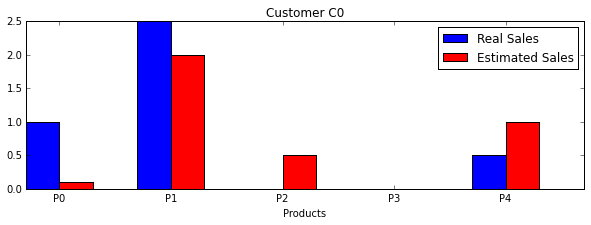

In [29]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

salesMatrix = np.array([[1,2.5,0,0,0.5], [0,1,0.5,1,0.5], [1,2,0,1,1], [0,0.5,0,0.3,0]])
salesMatrixEst = np.array([[0.1,2,0.5,0,1], [0.3,1.5,0.5,0.5,0.65], [0.6,3,1,1,1.3], [0.15,0.3,0.15,0.3,0.09]])

customerIndex = 0

bar_width = 0.3
fig = plt.figure(num=None, figsize=(10,3), dpi=80, facecolor='w', edgecolor='k')
plt.bar(np.arange(salesMatrix.shape[1]), salesMatrix[customerIndex,:],bar_width, color='b', label='Real Sales')
plt.bar(np.arange(salesMatrix.shape[1]) + bar_width, salesMatrixEst[customerIndex,:],bar_width, color='r', label='Estimated Sales')
plt.xlabel("Products")
plt.xticks(np.arange(5) + bar_width, ['P0','P1','P2','P3','P4'])
plotTitle = "Customer C%d" % customerIndex
plt.title(plotTitle)
plt.legend()
figureTitle = "../otherFiles/Section1_C%d.png" % customerIndex
plt.savefig(figureTitle)